# 7-day rolling average of confirmed cases, normalized to the maximum value
In this notebook we plot the 7-day rolling average of the confirmed cases for each Italian province, normalized to the maximum increase. The aim is to show the chronological and geographical evolution of the peak. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.colors
from matplotlib import gridspec
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv")
df = df.query("codice_provincia < 800")
df["increase"] =  df.groupby(['codice_provincia'])['totale_casi'].diff().fillna(0)
df["increase"][df["increase"] < 0] = 0

total = df.pivot("denominazione_provincia","data","totale_casi")

increase = df.pivot("denominazione_provincia", "data", "increase")
max_increase = increase.max(axis=1)

for prov in increase.index:
    increase.loc[prov] /= max_increase.loc[prov]

for prov in increase.index:
    increase.loc[prov] = increase.loc[prov].rolling(7).mean().fillna(0)
    
sorted_list = []
for prov in increase.index:
    dates = list(increase.loc[prov])
    sorted_list.append(dates.index(max(dates)))
    
total["order"] = sorted_list
total = total.sort_values(by="order",ascending=False)
total = total.drop(columns=["order"])

increase["order"] = sorted_list
increase = increase.sort_values(by="order",ascending=False)
increase = increase.drop(columns=["order"])

In [6]:
increase.shape

(107, 224)

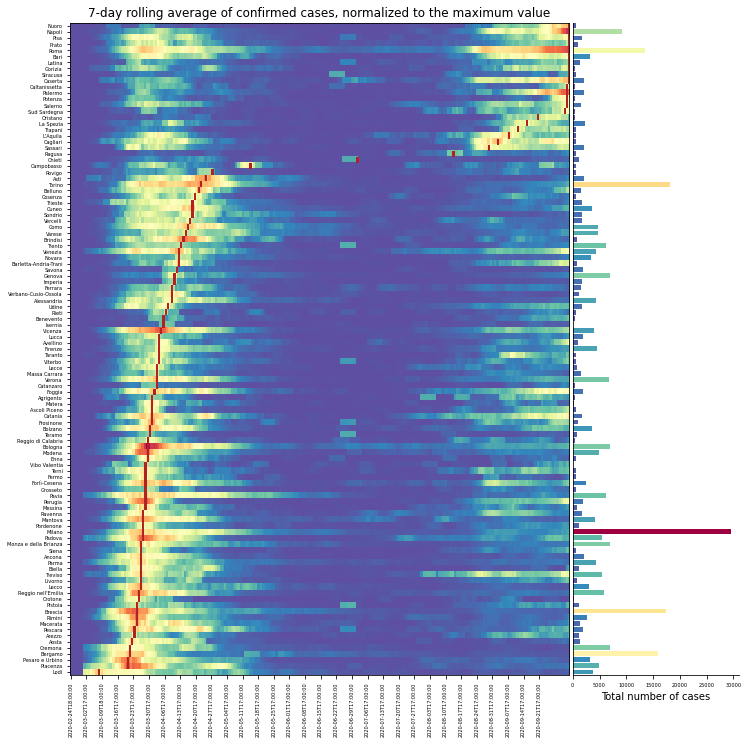

In [3]:
fig, axs = plt.subplots(1,2,figsize=(12,12),constrained_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1],wspace=0.01) 
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
im = ax.imshow(increase,cmap='Spectral_r',aspect='auto',interpolation='none')
ax.set_xticks(np.arange(0,incr,7,dtype=np.int32))
ax.set_xticklabels(increase.columns[::7],rotation=90)
ax.set_yticklabels(increase.index)
ax.set_yticks(np.arange(len(increase.index)))
ax.tick_params(labelsize=5)

for s in increase.index:
    y_coord = increase.index.get_loc(s)
    peak = increase.loc[s].max()
    x_coord = pd.Index(increase.loc[s]).get_loc(peak)
    if isinstance(x_coord,np.ndarray):
        x_coord = np.where(x_coord==True)[0][0]
    rect = plt.Rectangle((x_coord,y_coord-0.5),1,1,lw=0,fc='firebrick')
    ax.add_patch(rect)


y_pos = np.arange(len(increase.index))
totals = list(total.iloc[:,-1])
totals.reverse()
colors = cm.Spectral_r(np.array(totals) / float(max(totals)))
ax1.barh(y_pos, totals, color=colors)
ax1.set_yticks([],[])
ax1.set_ylim(min(y_pos)-0.5, max(y_pos)+0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("Total number of cases")
ax1.tick_params(labelsize=5)

ax.set_title("7-day rolling average of confirmed cases, normalized to the maximum value")
fig.savefig("cases.png",dpi=300)